# Roget's Thesaurus in the 21st Century

### In order to run this file

#### Option 1 (Recommended): Retrieve embeddings from csv files
- Go to https://1drv.ms/u/s!AuScx2RvugufgmIMs199k4HTRduC?e=3x37IZ, download the zip file and extract in the same folder as this ipynb file.
- Execute cells until [this point](#2.1-Run-API-to-fetch-embeddings).  
- Follow the next link to **2.2** and proceed from there (**skip 2.1**).

#### Option 2: Calculate embeddings from scratch
- The data (99K words) is divided in 4 DataFrames (approximately 25K each).
- The embeddings of the 4th DataFrame are calculated in this file, but the other three have a file of their own (each). Find the other .ipynb files inside this folder and **run them concurrently with 2.1**, for performance reasons. 
- Runnings all these takes time (**almost 3 hours**) and **requires an api_key from your OpenAI account** (plus sufficient balance in your account). 

## 1. Get Roget's Thesaurus Classification

We are going to crawl into the eBook's website (https://www.gutenberg.org/files/10681/old/20040627-10681-h-body-pos.htm#5) using the BeautifulSoup library.  
Crawling is done line by line, each time checking for certain criteria that either indicate a word to be added or to continue to the next line.

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import warnings

warnings. filterwarnings('ignore')

# Establish connection
r = requests.get("https://www.gutenberg.org/files/10681/old/20040627-10681-h-body-pos.htm#5")
html = r.text
soup = BeautifulSoup(html, 'html.parser')

wordList = [] # Words will be stored in here

count = 0 # Word count
flag = False # Start counting for words

# Examine each line in the page's html code, one by one
for line in str(soup).split('\n'):
    if 'ill can dwell in such a temple' in line: # Words end from this point onward, so break
        break
    if((']<' in line) and ('eBook #10681' not in line)): # Find words like "ens<I> [Lat.]</I>" and count them in
        mark = line.find('<')
        wordList.append(line[:mark])
        count += 1
        continue
    if ('<' in line) or ('>' in line): # If line contains < or > it does not have a word to add (exception above)
        continue
    if not line.strip(): # If line is empty continue to the next
        continue
    if line == "": # If line is empty continue to the next
        continue
    if '--' in line: # If -- in line continue to the next and begin counting words
        flag = True
        continue
    if(flag): # A lot of words end with , or . or other special characters. If last chars are not alpha(A-Z) remove them
        if not line[-1].isalpha():
            if not line[-2].isalpha():
                if not line[-3].isalpha():
                    wordList.append(line[:-3])
                else:
                    wordList.append(line[:-2])
            else:
                wordList.append(line[:-1])
        else:
            wordList.append(line)
        count += 1
    
data = pd.Series(wordList) # Store words into a Series for better processing
data

0           existence
1               being
2              entity
3                 ens
4                esse
             ...     
99882      cloistered
99883        monastic
99884     monasterial
99885      conventual
99886    ne vile fano
Length: 99887, dtype: object

- Exclude junk entries gathered during crawling.

In [2]:
data = data[data != ""]

In [3]:
data = data.reset_index(drop=True)
data

0           existence
1               being
2              entity
3                 ens
4                esse
             ...     
99548      cloistered
99549        monastic
99550     monasterial
99551      conventual
99552    ne vile fano
Length: 99553, dtype: object

- Create a DataFrame with the words gathered. The additional columns are for storing Roget's Classification by all levels (Class, Division, Section, Subsection).

In [4]:
data = pd.DataFrame({'word': data, 'Class': 0, 'Division': 0, 'Section': 0, 'Subsection': 'a'})
data

,word,Class,Division,Section,Subsection
0,existence,0,0,0,a
1,being,0,0,0,a
2,entity,0,0,0,a
3,ens,0,0,0,a
4,esse,0,0,0,a
...,...,...,...,...,...
99548,cloistered,0,0,0,a
99549,monastic,0,0,0,a
99550,monasterial,0,0,0,a
99551,conventual,0,0,0,a


- Crawl Project Gutenberg's site once more. This time, gather Classification.

In [5]:
cl = 0 # Class count
sec = 0 # Section count
div = 0 # Division count
sub = 0 # Subsection count

counter = 0 # Word count
start = False # Start counting

# Examine each line
for line in str(soup).split('\n'):
    if 'CLASS TITLE' in line: # Indicates a new Class
        start = True
        cl += 1
        sec = 0 # Reset sections
        div = 0 # Reset division
        continue
    if('DIVISION TITLE' in line): # Indicates a new Division
        div += 1
        sec = 0 # Reset sections
        continue
    if ('SECTION TITLE' in line) and 'SUB' not in line: # Indicates a new Section
        sec += 1
        continue
    if ('SUBSECTION TITLE' in line): # Indicates a new Subsection
        st = line.find('SUBSECTION TITLE') + 16
        end = line.find('">')
        sub = line[st:end] # Extract title only
        continue
    if counter > 99552: # End of word counter
        break
    if 'ill can dwell in such a temple' in line: # End of words in page
        break
    if((']<' in line) and ('eBook #10681' not in line) and flag and start): # Take into account words like ens<I> [Lat.]</I>
        data['Class'].iloc[counter] = cl
        data['Section'].iloc[counter] = sec
        data['Division'].iloc[counter] = div
        data['Subsection'].iloc[counter] = sub
        counter += 1
        continue
    if ('<' in line) or ('>' in line): # Not a word here
        continue
    if not line.strip(): # Blank line
        continue
    if '--' in line: # Start counting
        flag = True
        continue
    if(flag and start): # Update each word Category
        data['Class'].iloc[counter] = cl
        data['Section'].iloc[counter] = sec
        data['Division'].iloc[counter] = div
        data['Subsection'].iloc[counter] = sub
        counter += 1

data

,word,Class,Division,Section,Subsection
0,existence,1,0,1,"BEING, IN THE ABSTRACT"
1,being,1,0,1,"BEING, IN THE ABSTRACT"
2,entity,1,0,1,"BEING, IN THE ABSTRACT"
3,ens,1,0,1,"BEING, IN THE ABSTRACT"
4,esse,1,0,1,"BEING, IN THE ABSTRACT"
...,...,...,...,...,...
99548,cloistered,6,0,5,RELIGIOUS INSTITUTIONS
99549,monastic,6,0,5,RELIGIOUS INSTITUTIONS
99550,monasterial,6,0,5,RELIGIOUS INSTITUTIONS
99551,conventual,6,0,5,RELIGIOUS INSTITUTIONS


## 2. Fetch word Embeddings

### Model: OpenAI

We are going to use the API of OpenAI which has been trained on larger corpora.  
In particular we will use the **text-embedding-3-large** model which can generate embeddings with up to 3072 dimensions!
- First initiallize dataframe with vec column to store the embeddings.

In [6]:
size = data['word'].size # Word count = df size

embeddings = pd.DataFrame({'word': data['word'], 'vec': [None]*size}) # Init df
embeddings

,word,vec
0,existence,None
1,being,None
2,entity,None
3,ens,None
4,esse,None
...,...,...
99548,cloistered,None
99549,monastic,None
99550,monasterial,None
99551,conventual,None


##### If you want to **skip** the API calls and get embeddings from csv, continue [here](#2.2-Retrieve-embeddings-from-csv).

### 2.1 Run API to fetch embeddings

- Break the dataframe into 4 and run concurrently for performance reasons (approximately 25K each).

In [7]:
# All 3 run in their separate files
embeddings1 = embeddings[:25000].copy()
embeddings1.to_csv('emb1.csv')

embeddings2 = embeddings[25000:50000].copy()
embeddings2.to_csv('emb2.csv')

embeddings3 = embeddings[50000:75000].copy()
embeddings3.to_csv('embs3.csv')

In [8]:
# 4th run in this file below
embeddings4 = embeddings[75000:].copy()

In [9]:
embeddings4

,word,vec
75000,be off,None
75001,forfeit,None
75002,go from one's word,None
75003,palter,None
75004,stretch a point,None
...,...,...
99548,cloistered,None
99549,monastic,None
99550,monasterial,None
99551,conventual,None


- Use personal api-key to access the API (choose the large embedding model that provides vectors up to **3072 elements**).  
- Then, read each word and create the corresponding embedding vector.  
- Finally, store vector in our DataFrame.

In [21]:
from openai import OpenAI
client = OpenAI(api_key='my-key') # Establish connection

# for each word 
for i in range(embeddings4['word'].size):
    response = client.embeddings.create(
        input=embeddings4['word'][i], # Give input
        model="text-embedding-3-large" # Define model
    )
    embeddings4['vec'][i] = response.data[0].embedding # Extract output vector

- Store vectors to csv file.

In [22]:
embeddings4.to_csv('emb4L.csv')

### 2.2 Retrieve embeddings from csv

- Read all csv files and **concatenate** them into one large DataFrame.

In [7]:
csv_files = ['emb1L.csv', 'emb2L.csv', 'emb3L.csv', 'emb4L.csv']

dfs = []

for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all dataframes in the list
word_df = pd.concat(dfs, ignore_index=True)

- More cleaning.

In [8]:
del word_df['Unnamed: 0'] # When reading from csv an extra index column ['Unnamed: 0']  emerges

word_df = word_df.dropna() # Drop any na that emerges
word_df

,word,vec
0,existence,"[-0.012068594805896282, 0.0012747612781822681,..."
1,being,"[0.004383814055472612, 0.011128472164273262, 0..."
2,entity,"[-0.01941847987473011, -0.011283711530268192, ..."
3,ens,"[-0.0191356148570776, 0.01700943522155285, -0...."
4,esse,"[-0.013645762577652931, 0.02081446535885334, -..."
...,...,...
99548,cloistered,"[-0.01730913110077381, 0.02407379075884819, -0..."
99549,monastic,"[0.003755746642127633, 0.0026681367307901382, ..."
99550,monasterial,"[0.013391705229878426, 0.042107418179512024, -..."
99551,conventual,"[-0.0028714044019579887, 0.009492953307926655,..."


- Convert the ['vec'] column from **string** (default type from csv) to **float**, so we can process it properly.

In [9]:
word_df['vec2'] = None
for i in range(word_df['vec'].size):
    try:
        list_of_floats = [float(x) for x in word_df['vec'][i].strip('[]').split(',')]
        word_df['vec2'][i] = list_of_floats
    except(KeyError):
        continue

- Finally, drop **NaN** values.

In [10]:
word_df = word_df[:99549]
word_df['vec2']

0        [-0.012068594805896282, 0.0012747612781822681,...
1        [0.004383814055472612, 0.011128472164273262, 0...
2        [-0.01941847987473011, -0.011283711530268192, ...
3        [-0.0191356148570776, 0.01700943522155285, -0....
4        [-0.013645762577652931, 0.02081446535885334, -...
                               ...                        
99546    [0.008395938202738762, 0.03022841550409794, -0...
99547    [-0.022145207971334457, 0.012608639895915985, ...
99548    [-0.01730913110077381, 0.02407379075884819, -0...
99549    [0.003755746642127633, 0.0026681367307901382, ...
99550    [0.013391705229878426, 0.042107418179512024, -...
Name: vec2, Length: 99549, dtype: object

## 3. Clustering

### 3.1 Class Level Clustering

- Insert Class column (Roget's Classification).

In [11]:
word_df['Class'] = data['Class']
word_df

,word,vec,vec2,Class
0,existence,"[-0.012068594805896282, 0.0012747612781822681,...","[-0.012068594805896282, 0.0012747612781822681,...",1
1,being,"[0.004383814055472612, 0.011128472164273262, 0...","[0.004383814055472612, 0.011128472164273262, 0...",1
2,entity,"[-0.01941847987473011, -0.011283711530268192, ...","[-0.01941847987473011, -0.011283711530268192, ...",1
3,ens,"[-0.0191356148570776, 0.01700943522155285, -0....","[-0.0191356148570776, 0.01700943522155285, -0....",1
4,esse,"[-0.013645762577652931, 0.02081446535885334, -...","[-0.013645762577652931, 0.02081446535885334, -...",1
...,...,...,...,...
99546,cloister,"[0.008395938202738762, 0.03022841550409794, -0...","[0.008395938202738762, 0.03022841550409794, -0...",6
99547,claustral,"[-0.022145207971334457, 0.012608639895915985, ...","[-0.022145207971334457, 0.012608639895915985, ...",6
99548,cloistered,"[-0.01730913110077381, 0.02407379075884819, -0...","[-0.01730913110077381, 0.02407379075884819, -0...",6
99549,monastic,"[0.003755746642127633, 0.0026681367307901382, ...","[0.003755746642127633, 0.0026681367307901382, ...",6


Apply **KMeans** Clustering: 
- $K$ $=$ $number$ $of$ $Classes$ $=$ $6$, so we can compare the two Classifications.
- Convert values **into list** in order to feed the algorithm properly.
- Store result in new ['cluster'] column.

In [16]:
from sklearn.cluster import KMeans

# K Means clustering
kmeans = KMeans(n_clusters=6)  
kmeans.fit(word_df['vec2'].values.tolist())

# Fit and predict the cluster
word_df['cluster'] = kmeans.fit_predict(word_df['vec2'].values.tolist()) + 1

- Use **PCA** to plot the results.

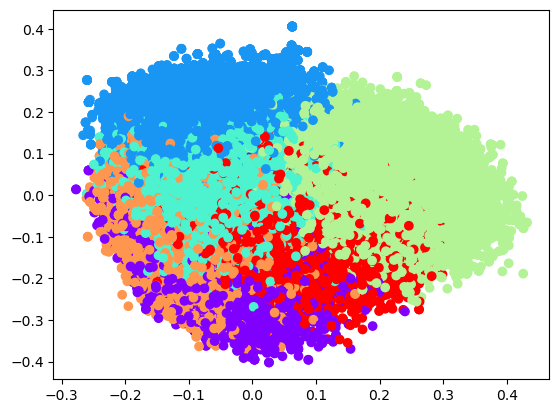

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
word_df['x'] = pca.fit_transform(word_df['vec2'].values.tolist())[:,0]
word_df['y'] = pca.fit_transform(word_df['vec2'].values.tolist())[:,1]

_ = plt.scatter(word_df['y'], word_df['x'], c=word_df['cluster'], cmap='rainbow')

- Plot the number of words for each class, for both classifications.

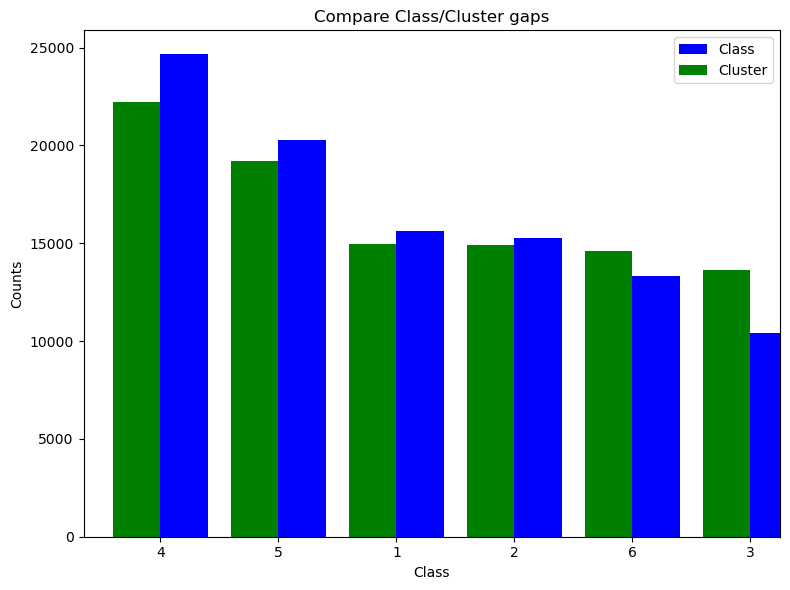

In [18]:
# Assuming you have already calculated value counts
value_counts_column1 = word_df['Class'].value_counts()
value_counts_column2 = word_df['cluster'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))

# Plotting value counts for Column 1
value_counts_column1.plot(kind='bar', color='blue', position=0, width=0.4, label='Class')

# Plotting value counts for Column 2
value_counts_column2.plot(kind='bar', color='green', position=1, width=0.4, label='Cluster')

plt.title('Compare Class/Cluster gaps')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.legend()

plt.tight_layout()
plt.show()

At first glance we can see that the 2 classifications do not differ much in numbers.

However, the proper way to compare the two, is with indexes like ***ARI*** or ***NMI***.
- ***The Adjusted Rand Index (ARI)*** is a measure of the similarity between two data clusterings. It is a correction of the Rand Index, which is a basic measure of similarity between two clusterings, but it has the disadvantage of being sensitive to chance.
- ***Normalized Mutual Information (NMI)*** is a valuable measure in clustering as it can provide an understanding of how similar two different sets of cluster assignments are, even if the number of clusters differ between the two sets. The function takes two label arrays as input, both representing different clustering assignments for the same dataset.

In [19]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix

ari = adjusted_rand_score(word_df['Class'], word_df['cluster'])
nmi = normalized_mutual_info_score(word_df['Class'], word_df['cluster'])
print('ARI Score: ' + str(ari))
print('NMI Score: ' + str(nmi))

ARI Score: 0.01144692289164093
NMI Score: 0.018914077399550037


Both measures indicate a poor correlation.

### 3.2 Section/Division Level Clustering

We are going to do clustering for **each Class/Section pair** and compare the results with the **sections** of Roget's Classification.
- First insert Sections and Divisions by Roget in our data.

In [17]:
word_df['Section'] = data['Section']
word_df['Division'] = data['Division']
word_df

,word,vec,vec2,Class,cluster,Section,Division
0,existence,"[-0.012068594805896282, 0.0012747612781822681,...","[-0.012068594805896282, 0.0012747612781822681,...",1,4,1,0
1,being,"[0.004383814055472612, 0.011128472164273262, 0...","[0.004383814055472612, 0.011128472164273262, 0...",1,4,1,0
2,entity,"[-0.01941847987473011, -0.011283711530268192, ...","[-0.01941847987473011, -0.011283711530268192, ...",1,4,1,0
3,ens,"[-0.0191356148570776, 0.01700943522155285, -0....","[-0.0191356148570776, 0.01700943522155285, -0....",1,4,1,0
4,esse,"[-0.013645762577652931, 0.02081446535885334, -...","[-0.013645762577652931, 0.02081446535885334, -...",1,4,1,0
...,...,...,...,...,...,...,...
99546,cloister,"[0.008395938202738762, 0.03022841550409794, -0...","[0.008395938202738762, 0.03022841550409794, -0...",6,5,5,0
99547,claustral,"[-0.022145207971334457, 0.012608639895915985, ...","[-0.022145207971334457, 0.012608639895915985, ...",6,2,5,0
99548,cloistered,"[-0.01730913110077381, 0.02407379075884819, -0...","[-0.01730913110077381, 0.02407379075884819, -0...",6,2,5,0
99549,monastic,"[0.003755746642127633, 0.0026681367307901382, ...","[0.003755746642127633, 0.0026681367307901382, ...",6,2,5,0


Create a new column containing a list of 2 elements: 
- Class
- Section/Division

In [18]:
# New list column
word_df['CSD'] = None

for i in word_df.index:
    if((word_df['Class'][i] == 4) or (word_df['Class'][i] == 5)): # If division then
        word_df['CSD'][i] = [word_df['Class'][i], word_df['Division'][i]]
        
    else: # If section then
        word_df['CSD'][i] = [word_df['Class'][i], word_df['Section'][i]]

In [19]:
word_df['CSD']

0        [1, 1]
1        [1, 1]
2        [1, 1]
3        [1, 1]
4        [1, 1]
          ...  
99546    [6, 5]
99547    [6, 5]
99548    [6, 5]
99549    [6, 5]
99550    [6, 5]
Name: CSD, Length: 99549, dtype: object

Next convert these Class/Section pairs **into unique integers** (1-24).
- 1 meaning [1,1] (Class I and Section I)
- 2 meaning [1,2] (Class I and Section II)...
- ...24 meaning [6,5] (Class VI and Section V)

In [20]:
word_df['Section/Division'] = 0 # New column

# Represents each list
unique_int = 0

# Make comparisons for each row in case the list changes
prev_list = [0, 0]

# When a new list appears (different class/section/division) increase unique_integer by 1
for i in word_df.index:
    if(prev_list[0] != word_df['CSD'][i][0]) or (prev_list[1] != word_df['CSD'][i][1]):
        unique_int += 1
        prev_list = word_df['CSD'][i] # New list for comparisons
        
    word_df['Section/Division'][i] = unique_int # Assign unique count for this list
    
word_df

,word,vec,vec2,Class,cluster,Section,Division,CSD,Section/Division
0,existence,"[-0.012068594805896282, 0.0012747612781822681,...","[-0.012068594805896282, 0.0012747612781822681,...",1,4,1,0,"[1, 1]",1
1,being,"[0.004383814055472612, 0.011128472164273262, 0...","[0.004383814055472612, 0.011128472164273262, 0...",1,4,1,0,"[1, 1]",1
2,entity,"[-0.01941847987473011, -0.011283711530268192, ...","[-0.01941847987473011, -0.011283711530268192, ...",1,4,1,0,"[1, 1]",1
3,ens,"[-0.0191356148570776, 0.01700943522155285, -0....","[-0.0191356148570776, 0.01700943522155285, -0....",1,4,1,0,"[1, 1]",1
4,esse,"[-0.013645762577652931, 0.02081446535885334, -...","[-0.013645762577652931, 0.02081446535885334, -...",1,4,1,0,"[1, 1]",1
...,...,...,...,...,...,...,...,...,...
99546,cloister,"[0.008395938202738762, 0.03022841550409794, -0...","[0.008395938202738762, 0.03022841550409794, -0...",6,5,5,0,"[6, 5]",24
99547,claustral,"[-0.022145207971334457, 0.012608639895915985, ...","[-0.022145207971334457, 0.012608639895915985, ...",6,2,5,0,"[6, 5]",24
99548,cloistered,"[-0.01730913110077381, 0.02407379075884819, -0...","[-0.01730913110077381, 0.02407379075884819, -0...",6,2,5,0,"[6, 5]",24
99549,monastic,"[0.003755746642127633, 0.0026681367307901382, ...","[0.003755746642127633, 0.0026681367307901382, ...",6,2,5,0,"[6, 5]",24


- Apply KMeans (**K = 24** as there are 24 total Class/Section pairs).

In [21]:
# K Means clustering
kmeans = KMeans(n_clusters=24)  # Number of total class/section pairs
kmeans.fit(word_df['vec2'].values.tolist())

# Fit and predict the cluster
word_df['cluster_Section'] = kmeans.fit_predict(word_df['vec2'].values.tolist()) + 1

- Use **PCA** to plot the results.

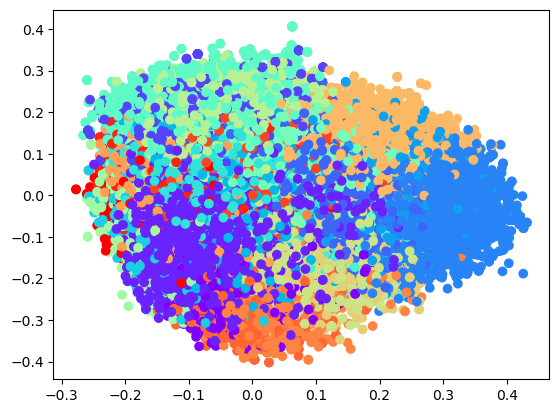

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
word_df['x'] = pca.fit_transform(word_df['vec2'].values.tolist())[:,0]
word_df['y'] = pca.fit_transform(word_df['vec2'].values.tolist())[:,1]

_ = plt.scatter(word_df['y'], word_df['x'], c=word_df['cluster_Section'], cmap='rainbow')

- Plot the number of words for each Section/Division, for both classifications.

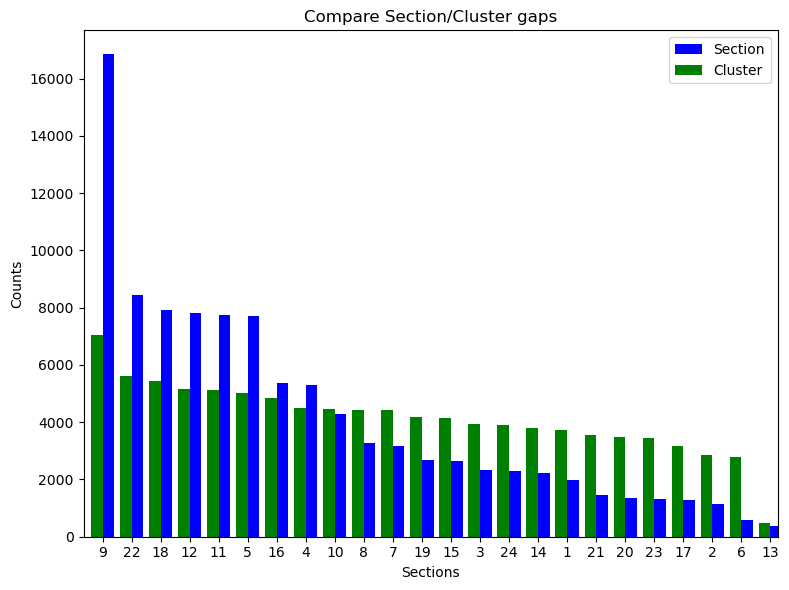

In [30]:
# Assuming you have already calculated value counts
value_counts_column1 = word_df['Section/Division'].value_counts()
value_counts_column2 = word_df['cluster_Section'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))

# Plotting value counts for Column 1
value_counts_column1.plot(kind='bar', color='blue', position=0, width=0.4, label='Section')

# Plotting value counts for Column 2
value_counts_column2.plot(kind='bar', color='green', position=1, width=0.4, label='Cluster')

plt.title('Compare Section/Cluster gaps')
plt.xlabel('Sections')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.legend()

plt.tight_layout()
plt.show()

Gaps between original Sections and Clustering Sections are larger in comparison with the gaps in Class level Clustering. 

- Calculate again both comparison measures.

In [27]:
ari = adjusted_rand_score(word_df['Section/Division'], word_df['cluster_Section'])
nmi = normalized_mutual_info_score(word_df['Section/Division'], word_df['cluster_Section'])
print('ARI Score: ' + str(ari))
print('NMI Score: ' + str(nmi))

ARI Score: 0.015384200799489054
NMI Score: 0.06019484301880097


Both scores indecate poor similarity.

## 4. Classification

The classification model will be a **neural network** and we will measure its **accuracy** in both cases.
- Input: word vector (embedding)
- Hidden Layers: None
- Output: Class (1-6)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import numpy as np

### 4.1 Class Level Prediction

- Build and train the model

In [26]:
# Convert embedding vectors to numpy arrays
X = np.array(word_df['vec2'].tolist())

# Encode class labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(word_df['Class'])

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 

# Define the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
 
    Dense(len(np.unique(y)), activation='softmax') 
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Define metrics and loss

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, 
                    validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


Epoch 1/50


934/934 [==============================] - 20s 19ms/step - loss: 1.2793 - accuracy: 0.5184 - val_loss: 1.1704 - val_accuracy: 0.5599
Epoch 2/50
934/934 [==============================] - 16s 17ms/step - loss: 1.1790 - accuracy: 0.5549 - val_loss: 1.1511 - val_accuracy: 0.5678
Epoch 3/50
934/934 [==============================] - 16s 17ms/step - loss: 1.1384 - accuracy: 0.5710 - val_loss: 1.1271 - val_accuracy: 0.5780
Epoch 4/50
934/934 [==============================] - 17s 19ms/step - loss: 1.1056 - accuracy: 0.5825 - val_loss: 1.1281 - val_accuracy: 0.5773
Epoch 5/50
934/934 [==============================] - 18s 19ms/step - loss: 1.0815 - accuracy: 0.5907 - val_loss: 1.1195 - val_accuracy: 0.5803
Epoch 6/50
934/934 [==============================] - 16s 17ms/step - loss: 1.0558 - accuracy: 0.6005 - val_loss: 1.1311 - val_accuracy: 0.5758
Epoch 7/50
934/934 [==============================] - 15s 16ms/step - loss: 1.0351 - accuracy: 0.6066 - val_loss: 1.1162 - val_accura

Plot the results for both **accuracy** and **loss**.
- As **accuracy** keeps increasing the validation seems to be stable in **0.58**.  
- As **loss** keeps decreasing the validation seems to be stable in **1.14**. 

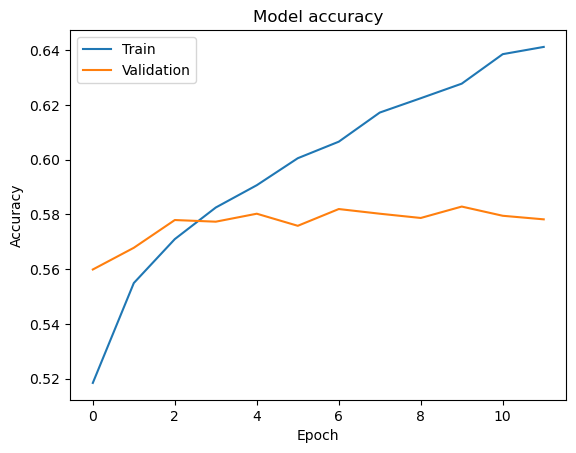

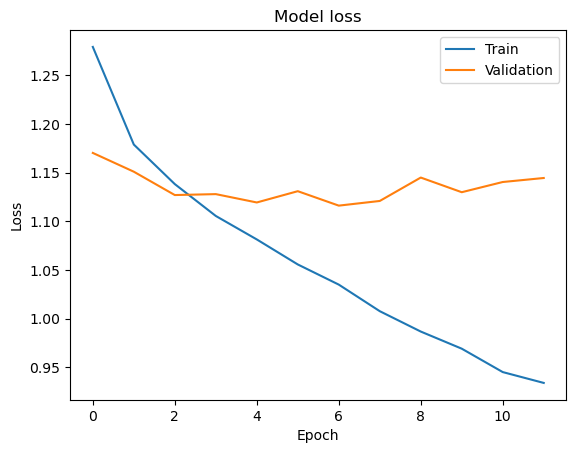

In [27]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

- Plot **confusion matrix** (we can see a lot of mismatched values for all 6 classes).

623/623 [==============================] - 2s 3ms/step


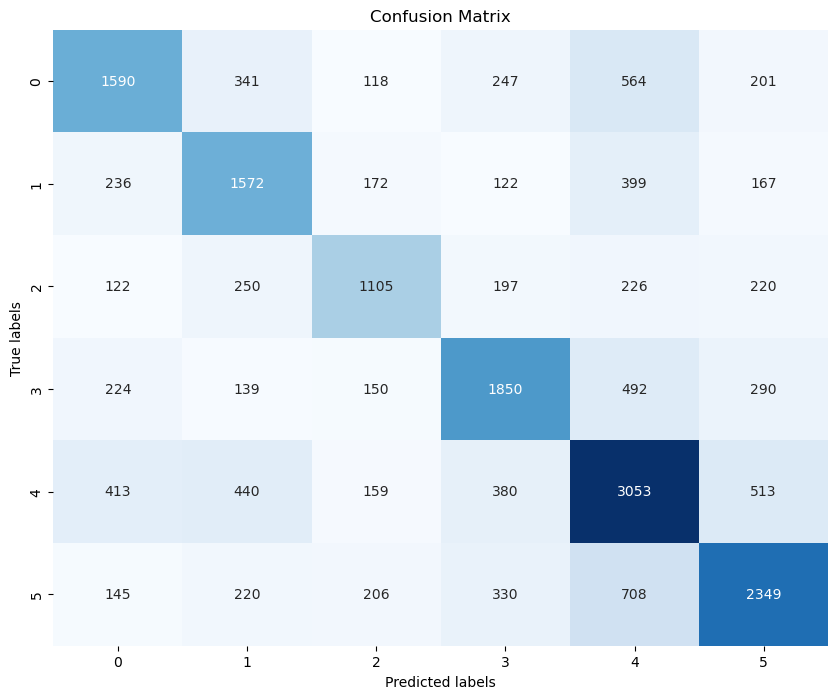

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Classification report also indicates all scores to be around **60%**.

- **Accuracy**: Measures the proportion of correctly classified instances out of the total instances.

- **Precision**: Indicates the proportion of true positive predictions out of all positive predictions made by the model.

- **Recall (Sensitivity)**: Measures the proportion of true positive predictions out of all actual positive instances in the data.

- **F1-Score**: Harmonic mean of precision and recall, providing a balance between the two metrics.

In [29]:
from sklearn.metrics import classification_report

class_names = [str(label) for label in label_encoder.classes_]

# Generate classification report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           1       0.58      0.52      0.55      3061
           2       0.53      0.59      0.56      2668
           3       0.58      0.52      0.55      2120
           4       0.59      0.59      0.59      3145
           5       0.56      0.62      0.59      4958
           6       0.63      0.59      0.61      3958

    accuracy                           0.58     19910
   macro avg       0.58      0.57      0.57     19910
weighted avg       0.58      0.58      0.58     19910



### 4.2 Section/Division Level Prediction

In order to predict a word's section/division we must take into account its class first. We will use the **['Section/Division'] column** calculated before, for section clustering.  

- Build and train the model

In [33]:
# Convert embedding vectors to numpy arrays
X = np.array(word_df['vec2'].tolist())

# Encode class labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(word_df['Section/Division']) # Int representing each Class/Section pair

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 

# Define the model
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
 
    Dense(len(np.unique(y)), activation='softmax') 
])

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Adjust learning rate if needed
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Epoch 1/50
1867/1867 [==============================] - 62s 32ms/step - loss: 2.3992 - accuracy: 0.3308 - val_loss: 1.8832 - val_accuracy: 0.4285
Epoch 2/50
1867/1867 [==============================] - 55s 30ms/step - loss: 1.9909 - accuracy: 0.4004 - val_loss: 1.8451 - val_accuracy: 0.4374
Epoch 3/50
1867/1867 [==============================] - 55s 30ms/step - loss: 1.9111 - accuracy: 0.4191 - val_loss: 1.8220 - val_accuracy: 0.4446
Epoch 4/50
1867/1867 [==============================] - 55s 29ms/step - loss: 1.8570 - accuracy: 0.4312 - val_loss: 1.8034 - val_accuracy: 0.4465
Epoch 5/50
1867/1867 [==============================] - 52s 28ms/step - loss: 1.8052 - accuracy: 0.4439 - val_loss: 1.7802 - val_accuracy: 0.4550
Epoch 6/50
1867/1867 [==============================] - 51s 27ms/step - loss: 1.7566 - accuracy: 0.4573 - val_loss: 1.7739 - val_accuracy: 0.4575
Epoch 7/50
1867/1867 [==============================] - 57s 30ms/step - loss: 1.7186 - accuracy: 0.4650 - val_loss: 1.7597 -

Plot the results for both **accuracy** and **loss**.
- As **accuracy** keeps increasing the validation seems to be stable in **0.45**.  
- As **loss** keeps decreasing the validation seems to be stable in **1.80**. 

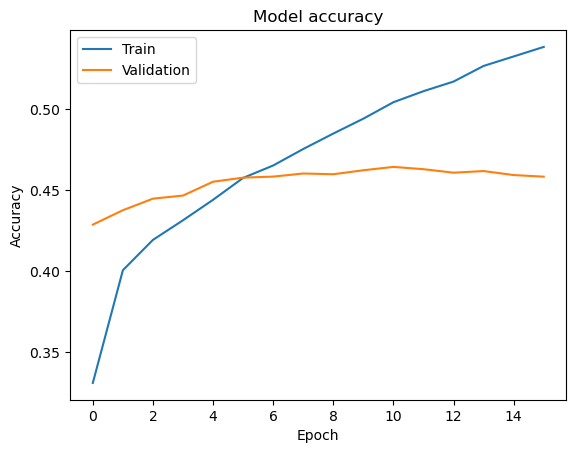

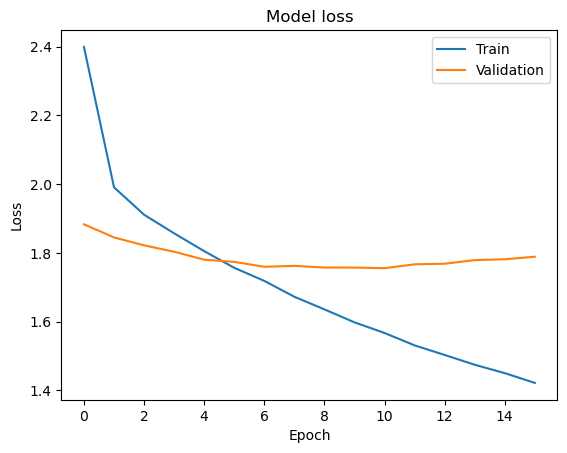

In [34]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Plot **confusion matrix** 
- We can see most of the false predicted values are around number 17.

623/623 [==============================] - 4s 6ms/step


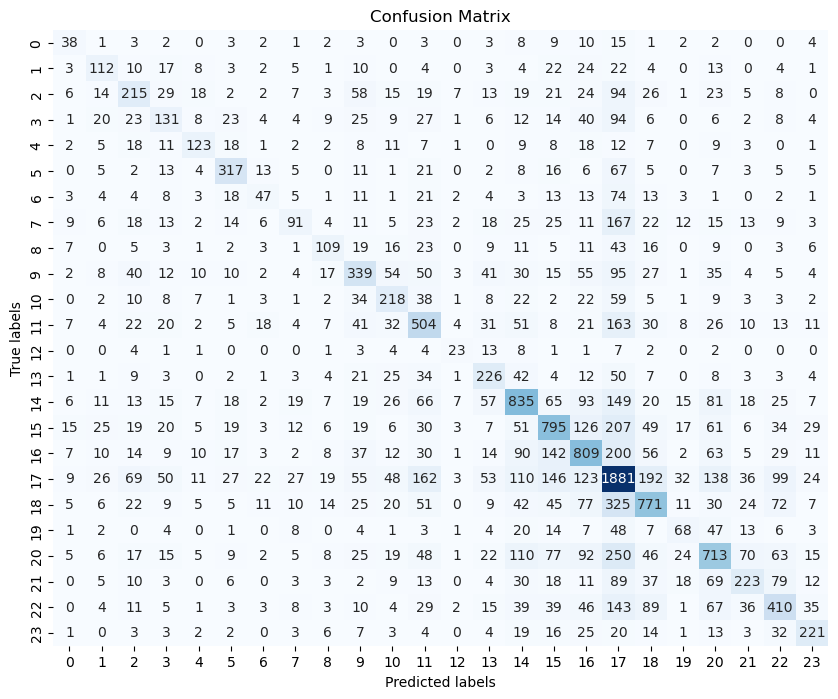

In [35]:
# Get predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [36]:
# Find class-section pairs with values close to 17 
word_df[word_df['Section/Division'] > 15]['CSD']

39008    [4, 1]
39009    [4, 1]
39010    [4, 1]
39011    [4, 1]
39012    [4, 1]
          ...  
99546    [6, 5]
99547    [6, 5]
99548    [6, 5]
99549    [6, 5]
99550    [6, 5]
Name: CSD, Length: 60543, dtype: object

This means that most mistakes were made at **classes 4,5 and 6**.

Classification report for each Class/Section pair.

In [37]:
class_names = [str(label) for label in label_encoder.classes_]

# Generate classification report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           1       0.30      0.34      0.32       112
           2       0.40      0.41      0.41       272
           3       0.38      0.34      0.36       629
           4       0.32      0.27      0.30       477
           5       0.53      0.45      0.48       276
           6       0.60      0.61      0.61       516
           7       0.31      0.18      0.23       255
           8       0.40      0.17      0.24       524
           9       0.46      0.36      0.41       302
          10       0.43      0.39      0.41       863
          11       0.40      0.47      0.44       461
          12       0.42      0.48      0.45      1042
          13       0.37      0.31      0.33        75
          14       0.40      0.49      0.44       464
          15       0.52      0.53      0.53      1581
          16       0.52      0.51      0.52      1564
          17       0.48      0.51      0.50      1581
          18       0.44    